# Self-Play PPO Agent

Starting enhanced PPO training with self-play...
Starting PPO training with self-play...
Episode 0, Reward: 26.35, Moves: 15
Episode 25, Reward: 0.75, Moves: 7
Episode 50, Reward: 40.65, Moves: 34
Episode 75, Reward: 3.10, Moves: 27
Episode 100:
  Avg Reward: 21.70
  Win Rate: 56.4% | Valid Move Rate: 98.0%
  W:57 L:42 D:0 I:2
Episode 125, Reward: 0.90, Moves: 7
Episode 150, Reward: 21.05, Moves: 11
Episode 175, Reward: 22.00, Moves: 14
Episode 200:
  Avg Reward: 23.82
  Win Rate: 56.0% | Valid Move Rate: 99.0%
  W:56 L:43 D:0 I:1
Episode 225, Reward: 17.90, Moves: 23
Episode 250, Reward: 32.35, Moves: 26
Episode 275, Reward: 27.80, Moves: 21
Episode 300:
  Avg Reward: 27.64
  Win Rate: 62.0% | Valid Move Rate: 100.0%
  W:62 L:38 D:0 I:0
Episode 325, Reward: 1.65, Moves: 17
Episode 350, Reward: 22.40, Moves: 21
Episode 375, Reward: 1.65, Moves: 17
Episode 400:
  Avg Reward: 22.03
  Win Rate: 61.0% | Valid Move Rate: 100.0%
  W:61 L:39 D:0 I:0
Episode 425, Reward: 2.00, Moves: 19
Episod

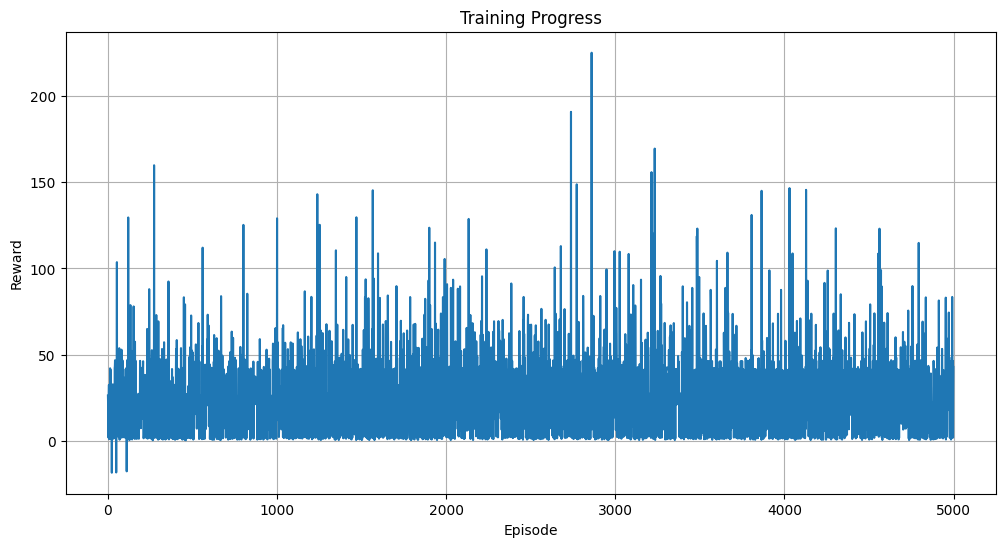


Training and evaluation complete!


In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import random
import matplotlib.pyplot as plt
from collections import deque
import copy


class ConnectX:
    """Unified ConnectX environment for both training and evaluation"""
    def __init__(self, rows=6, cols=7, inarow=4):
        self.rows = rows
        self.cols = cols
        self.inarow = inarow
        self.reset()

    def reset(self):
        self.board = np.zeros((self.rows, self.cols), dtype=int)
        self.current_player = 1
        self.done = False
        self.winner = None
        self.last_action = None
        return self._get_observation()

    def _get_observation(self):
        board_1d = []
        for col in range(self.cols):
            for row in range(self.rows):
                board_1d.append(self.board[row, col])
        return {
            'board': board_1d,
            'mark': self.current_player,
            'current_player': self.current_player
        }

    def get_valid_actions(self):
        return [col for col in range(self.cols) if self.board[0, col] == 0]

    def get_valid_actions_mask(self):
        return np.array([self.board[0, col] == 0 for col in range(self.cols)], dtype=bool)

    def step(self, action):
        if self.done:
            return self._get_observation(), 0, True, {}

        if not self._is_valid_action(action):
            self.done = True
            self.winner = 3 - self.current_player
            return self._get_observation(), -20, True, {'invalid_move': True}

        row = self._execute_move(action, self.current_player)
        self.last_action = (row, action)

        if self._check_win(row, action, self.current_player):
            self.done = True
            self.winner = self.current_player
            return self._get_observation(), 20, True, {'winner': self.current_player}

        if len(self.get_valid_actions()) == 0:
            self.done = True
            self.winner = 0
            return self._get_observation(), 5, True, {'draw': True}

        self.current_player = 3 - self.current_player
        return self._get_observation(), 0.1, self.done, {}

    def _is_valid_action(self, action):
        return 0 <= action < self.cols and self.board[0, action] == 0

    def _execute_move(self, action, player):
        for row in range(self.rows - 1, -1, -1):
            if self.board[row, action] == 0:
                self.board[row, action] = player
                return row
        return -1

    def _check_win(self, row, col, player):
        directions = [(0, 1), (1, 0), (1, 1), (1, -1)]
        for dr, dc in directions:
            count = 1
            r, c = row + dr, col + dc
            while 0 <= r < self.rows and 0 <= c < self.cols and self.board[r, c] == player:
                count += 1
                r, c = r + dr, c + dc
            r, c = row - dr, col - dc
            while 0 <= r < self.rows and 0 <= c < self.cols and self.board[r, c] == player:
                count += 1
                r, c = r - dr, c - dc
            if count >= self.inarow:
                return True
        return False

    def render(self):
        print("\n" + "="*17)
        for row in self.board:
            print("|" + "|".join(" " if cell == 0 else str(cell) for cell in row) + "|")
        print("="*17)
        print(" " + " ".join(str(i) for i in range(self.cols)))

class PPONetwork(nn.Module):
    def __init__(self, input_size, hidden_size, action_size):
        super(PPONetwork, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.LayerNorm(hidden_size // 2),
            nn.ReLU()
        )

        # Larger actor-critic heads
        self.actor = nn.Sequential(
            nn.Linear(hidden_size // 2, hidden_size // 2),
            nn.LayerNorm(hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, action_size)
        )
        self.critic = nn.Sequential(
            nn.Linear(hidden_size // 2, hidden_size // 2),
            nn.LayerNorm(hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1)
        )
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            torch.nn.init.constant_(m.bias, 0)

    def forward(self, state, valid_mask=None):
        shared_features = self.shared(state)
        action_logits = self.actor(shared_features)
        state_value = self.critic(shared_features)

        if valid_mask is not None:
            action_logits = action_logits.masked_fill(~valid_mask, -1e8)

        return action_logits, state_value

    def act(self, state, valid_mask, epsilon=0.1):
        action_logits, _ = self.forward(state, valid_mask)
        action_probs = F.softmax(action_logits, dim=-1)

        if random.random() < epsilon:
            valid_actions = torch.where(valid_mask)[0]
            return random.choice(valid_actions).item(), None

        dist = Categorical(action_probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.item(), log_prob

    def evaluate(self, states, actions, valid_masks):
        action_logits, state_values = self.forward(states, valid_masks)
        action_probs = F.softmax(action_logits, dim=-1)
        dist = Categorical(action_probs)
        action_logprobs = dist.log_prob(actions)
        dist_entropy = dist.entropy()
        return action_logprobs, state_values.squeeze(), dist_entropy

class PPOMemory:
    def __init__(self):
        self.clear_memory()

    def clear_memory(self):
        self.states = []
        self.actions = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
        self.valid_masks = []

class PPOAgent:
    def __init__(self, state_dim, action_dim, lr=0.0001, gamma=0.95, K_epochs=8, eps_clip=0.1, hidden_size=512):
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs

        self.policy = PPONetwork(state_dim, hidden_size, action_dim)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr, eps=1e-5)
        self.policy_old = PPONetwork(state_dim, hidden_size, action_dim)
        self.policy_old.load_state_dict(self.policy.state_dict())
        self.MseLoss = nn.MSELoss()

    def select_action(self, state, valid_mask, epsilon=0.1):
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0)
            valid_mask = torch.tensor(valid_mask, dtype=torch.bool).unsqueeze(0)
            action, log_prob = self.policy_old.act(state, valid_mask, epsilon)
        return action, log_prob.item() if log_prob is not None else None

    def update(self, memory):
        old_states = torch.FloatTensor(np.array(memory.states))
        old_actions = torch.LongTensor(memory.actions)
        old_logprobs = torch.FloatTensor([lp if lp is not None else 0 for lp in memory.logprobs])
        old_masks = torch.tensor(np.array(memory.valid_masks), dtype=torch.bool)

        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)

        rewards = torch.FloatTensor(rewards)
        if len(rewards) > 1 and rewards.std() > 0:
            rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-8)

        for _ in range(self.K_epochs):
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions, old_masks)
            ratios = torch.exp(logprobs - old_logprobs.detach())
            advantages = rewards - state_values
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
            actor_loss = -torch.min(surr1, surr2).mean()
            critic_loss = 0.5 * self.MseLoss(state_values, rewards)
            entropy_loss = -0.01 * dist_entropy.mean()
            loss = actor_loss + critic_loss + entropy_loss
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
            self.optimizer.step()

        self.policy_old.load_state_dict(self.policy.state_dict())

def calculate_strategic_reward(board_1d, action, player, last_action=None):
    if len(board_1d) < 42:
        return 0.0

    board = np.array(board_1d[:42]).reshape(6, 7)
    reward = 0.0

    # Center control bonus (column 3 is center)
    center_bonus = [0.05, 0.1, 0.2, 0.3, 0.2, 0.1, 0.05]
    reward += center_bonus[action]

    # Find landing row
    land_row = -1
    for row in range(5, -1, -1):
        if board[row, action] == 0:
            land_row = row
            break

    if land_row >= 0:
        # Temporarily place piece
        board[land_row, action] = player

        # Check for threats and opportunities in all directions
        directions = [(0, 1), (1, 0), (1, 1), (1, -1)]
        for dr, dc in directions:
            # Check for our potential wins
            count_own = 1
            open_ends = 0

            # Positive direction
            r, c = land_row + dr, action + dc
            while 0 <= r < 6 and 0 <= c < 7:
                if board[r, c] == player:
                    count_own += 1
                elif board[r, c] == 0:
                    open_ends += 1
                    break
                else:
                    break
                r, c = r + dr, c + dc

            # Negative direction
            r, c = land_row - dr, action - dc
            while 0 <= r < 6 and 0 <= c < 7:
                if board[r, c] == player:
                    count_own += 1
                elif board[r, c] == 0:
                    open_ends += 1
                    break
                else:
                    break
                r, c = r - dr, c - dc

            # Reward based on potential
            if count_own >= 4:
                reward += 20.0  # Immediate win
            elif count_own == 3 and open_ends >= 1:
                reward += 5.0   # Three in a row with open end
            elif count_own == 2 and open_ends >= 2:
                reward += 1.0   # Two in a row with two open ends

            # Check for opponent threats to block
            opponent = 2 if player == 1 else 1
            count_opp = 0
            opp_open_ends = 0

            # Positive direction for opponent
            r, c = land_row + dr, action + dc
            while 0 <= r < 6 and 0 <= c < 7:
                if board[r, c] == opponent:
                    count_opp += 1
                elif board[r, c] == 0:
                    opp_open_ends += 1
                    break
                else:
                    break
                r, c = r + dr, c + dc

            # Negative direction for opponent
            r, c = land_row - dr, action - dc
            while 0 <= r < 6 and 0 <= c < 7:
                if board[r, c] == opponent:
                    count_opp += 1
                elif board[r, c] == 0:
                    opp_open_ends += 1
                    break
                else:
                    break
                r, c = r - dr, c - dc

            # Reward for blocking opponent threats
            if count_opp >= 3 and opp_open_ends >= 1:
                reward += 4.0  # Block opponent's three in a row
            elif count_opp == 2 and opp_open_ends >= 2:
                reward += 0.5  # Block opponent's two with potential

    return reward

def preprocess_state(obs):
    if isinstance(obs, dict):
        board = obs['board']
        current_player = obs.get('current_player', 1)
    else:
        board = obs.board if hasattr(obs, 'board') else obs
        current_player = 1

    normalized_board = []
    for cell in board:
        if cell == 0:
            normalized_board.append(0.0)
        elif cell == 1:
            normalized_board.append(1.0)
        else:
            normalized_board.append(-1.0)

    normalized_board.append(1.0 if current_player == 1 else -1.0)
    return np.array(normalized_board, dtype=np.float32)

def train_with_self_play():
    state_dim = 43
    action_dim = 7
    max_episodes = 5000
    max_timesteps = 100
    update_timestep = 2048
    lr = 0.0001
    gamma = 0.95
    K_epochs = 8
    eps_clip = 0.1
    hidden_size = 512

    # Initialize environment and agent
    env = ConnectX()
    agent = PPOAgent(state_dim, action_dim, lr, gamma, K_epochs, eps_clip, hidden_size)
    memory = PPOMemory()

    # Training stats
    episode_rewards = []
    game_stats = {'wins': 0, 'losses': 0, 'draws': 0, 'invalid': 0}
    running_reward = 0
    time_step = 0

    # Self-play opponent (starts as copy of main agent)
    opponent = PPOAgent(state_dim, action_dim, lr, gamma, K_epochs, eps_clip, hidden_size)
    opponent.policy.load_state_dict(agent.policy.state_dict())

    print("Starting PPO training with self-play...")

    for episode in range(max_episodes):
        obs = env.reset()
        state = preprocess_state(obs)
        episode_reward = 0
        moves_made = 0
        current_agent = agent  # Start with our agent

        # Alternate who starts first
        if episode % 2 == 0:
            env.current_player = 1
        else:
            env.current_player = 2

        for t in range(max_timesteps):
            time_step += 1
            moves_made += 1

            valid_mask = env.get_valid_actions_mask()

            # Select action based on current player
            if env.current_player == 1:
                action, log_prob = current_agent.select_action(state, valid_mask,
                                                              epsilon=max(0.1 - episode/2000, 0.01))
            else:
                # Opponent's turn (could be random or another agent)
                if episode < 1000:  # First 1000 episodes use random opponent
                    action = random.choice(env.get_valid_actions())
                    log_prob = None
                else:  # After 1000 episodes use self-play opponent
                    action, log_prob = opponent.select_action(state, valid_mask,
                                                              epsilon=max(0.1 - episode/2000, 0.01))

            next_obs, reward, done, info = env.step(action)

            # Calculate strategic reward
            if 'invalid_move' in info:
                reward = -20
                game_stats['invalid'] += 1
            elif done:
                if 'winner' in info:
                    if info['winner'] == 1:
                        reward = 20 + calculate_strategic_reward(state[:42], action, 1, env.last_action)
                        game_stats['wins'] += 1
                    else:
                        reward = -20
                        game_stats['losses'] += 1
                elif 'draw' in info:
                    reward = 5
                    game_stats['draws'] += 1
            else:
                reward = 0.1 + calculate_strategic_reward(state[:42], action, 1, env.last_action)

            # Store experience for current player only
            if env.current_player == 1:
                memory.states.append(state)
                memory.actions.append(action)
                memory.logprobs.append(log_prob)
                memory.rewards.append(reward)
                memory.is_terminals.append(done)
                memory.valid_masks.append(valid_mask)

            state = preprocess_state(next_obs)
            episode_reward += reward if env.current_player == 1 else 0

            if time_step % update_timestep == 0 and env.current_player == 1:
                agent.update(memory)
                memory.clear_memory()

            if done:
                # Update opponent periodically
                if episode > 1000 and episode % 100 == 0:
                    opponent.policy.load_state_dict(agent.policy.state_dict())
                break

        episode_rewards.append(episode_reward)
        running_reward += episode_reward

        if episode % 100 == 0 and episode > 0:
            avg_reward = running_reward / 100
            total_games = sum(game_stats.values())
            win_rate = game_stats['wins'] / max(total_games, 1) * 100
            valid_rate = (total_games - game_stats['invalid']) / max(total_games, 1) * 100

            print(f'Episode {episode}:')
            print(f'  Avg Reward: {avg_reward:.2f}')
            print(f'  Win Rate: {win_rate:.1f}% | Valid Move Rate: {valid_rate:.1f}%')
            print(f'  W:{game_stats["wins"]} L:{game_stats["losses"]} D:{game_stats["draws"]} I:{game_stats["invalid"]}')

            running_reward = 0
            game_stats = {'wins': 0, 'losses': 0, 'draws': 0, 'invalid': 0}

        elif episode % 25 == 0:
            print(f'Episode {episode}, Reward: {episode_reward:.2f}, Moves: {moves_made}')

    return agent, episode_rewards


def evaluate_agent(agent, num_games=100):
    """Evaluate the agent against a random opponent using the same environment"""
    env = ConnectX()
    results = {'wins': 0, 'losses': 0, 'draws': 0, 'invalid': 0}

    for game in range(num_games):
        obs = env.reset()
        done = False
        moves = 0

        # Alternate who starts
        if game % 2 == 0:
            env.current_player = 1  # Agent starts
        else:
            env.current_player = 2  # Random starts

        while not done and moves < 42:
            state = preprocess_state(obs)
            valid_mask = env.get_valid_actions_mask()

            if env.current_player == 1:  # Agent's turn
                action, _ = agent.select_action(state, valid_mask, epsilon=0.0)
            else:  # Random opponent's turn
                action = random.choice(env.get_valid_actions())

            obs, _, done, info = env.step(action)
            moves += 1

            if done:
                if 'winner' in info:
                    if info['winner'] == 1:
                        results['wins'] += 1
                    else:
                        results['losses'] += 1
                elif 'draw' in info:
                    results['draws'] += 1
                elif 'invalid_move' in info:
                    results['invalid'] += 1

    return results

def play_demo_game(agent):
    """Play a demo game with visualization"""
    env = ConnectX()
    obs = env.reset()
    done = False
    moves = 0

    print("\n" + "="*30 + " DEMO GAME " + "="*30)
    env.render()

    while not done and moves < 42:
        state = preprocess_state(obs)
        valid_mask = env.get_valid_actions_mask()

        if env.current_player == 1:
            print(f"Agent's turn (Player 1):")
            action, _ = agent.select_action(state, valid_mask, epsilon=0.0)
            print(f"Agent chooses column: {action}")
        else:
            print(f"Random opponent's turn (Player 2):")
            action = random.choice(env.get_valid_actions())
            print(f"Random chooses column: {action}")

        obs, _, done, info = env.step(action)
        env.render()
        moves += 1

        if done:
            if 'winner' in info:
                print(f"Player {info['winner']} WINS!")
            elif 'draw' in info:
                print("DRAW!")
            elif 'invalid_move' in info:
                print("INVALID MOVE! Game over.")
            break

    print(f"Game ended after {moves} moves")

if __name__ == "__main__":
    print("Starting enhanced PPO training with self-play...")
    trained_agent, episode_rewards = train_with_self_play()
    torch.save(trained_agent.policy.state_dict(), 'ppo_connectx_selfplay.pth')

    # Evaluation
    print("\n" + "="*60)
    print("EVALUATION RESULTS")
    print("="*60)
    results = evaluate_agent(trained_agent, num_games=200)

    total_games = sum(results.values())
    print(f"\nOVERALL PERFORMANCE ({total_games} games):")
    print(f"  Win Rate: {results['wins']/total_games*100:.1f}%")
    print(f"  Loss Rate: {results['losses']/total_games*100:.1f}%")
    print(f"  Draw Rate: {results['draws']/total_games*100:.1f}%")
    print(f"  Invalid Rate: {results['invalid']/total_games*100:.1f}%")

    # Demo game
    play_demo_game(trained_agent)

    # Plot training progress
    plt.figure(figsize=(12, 6))
    plt.plot(episode_rewards)
    plt.title("Training Progress")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.grid(True)
    plt.show()

    print("\nTraining and evaluation complete!")


# PPO + MCTS Hybrid with Phased Training

Starting  PPO training
Starting superhuman PPO training with phased approach...
Episode 0 (initial): Reward: 46.35, Moves: 35
Episode 25 (initial): Reward: 4.50, Moves: 22
Episode 50 (initial): Reward: 2.65, Moves: 12
Episode 75 (initial): Reward: 23.70, Moves: 21
Episode 100 (initial, phase 100):
  Avg Reward: 34.35
  Win Rate: 72.3% | Valid Move Rate: 95.0%
  W:73 L:22 D:1 I:5
  Opponent Difficulty: 1.0
Episode 125 (initial): Reward: 23.24, Moves: 17
Episode 150 (initial): Reward: 3.85, Moves: 20
Episode 175 (initial): Reward: 36.05, Moves: 30
Episode 200 (initial, phase 200):
  Avg Reward: 32.16
  Win Rate: 70.0% | Valid Move Rate: 100.0%
  W:70 L:30 D:0 I:0
  Opponent Difficulty: 1.0
Episode 225 (initial): Reward: 3.20, Moves: 20
Episode 250 (initial): Reward: 2.97, Moves: 18
Episode 275 (initial): Reward: 23.44, Moves: 17
Episode 300 (initial, phase 300):
  Avg Reward: 29.35
  Win Rate: 66.0% | Valid Move Rate: 95.0%
  W:66 L:29 D:0 I:5
  Opponent Difficulty: 1.0
Episode 325 (init

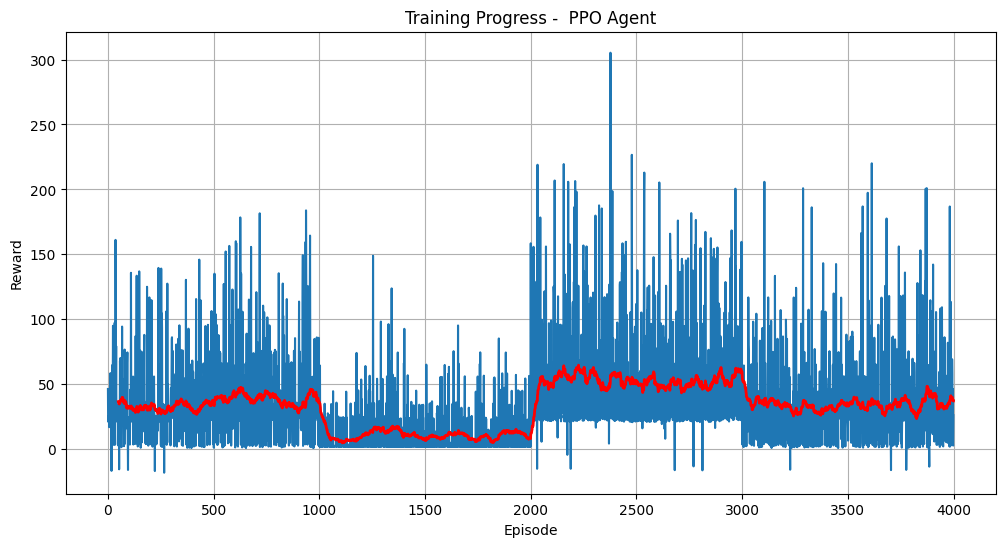


EVALUATION RESULTS AGAINST DIFFERENT OPPONENTS

Against Random:
  Wins: 27 (54.0%)
  Losses: 23
  Draws: 0
  Invalid: 0
  Average game length: 22.6 moves

Against Rule-Based (Difficulty 3):
  Wins: 6 (12.0%)
  Losses: 44
  Draws: 0
  Invalid: 0
  Average game length: 13.7 moves

Against Rule-Based (Difficulty 5):
  Wins: 0 (0.0%)
  Losses: 50
  Draws: 0
  Invalid: 0
  Average game length: 14.2 moves

Against MCTS (100 iterations):
  Wins: 42 (84.0%)
  Losses: 6
  Draws: 2
  Invalid: 0
  Average game length: 26.0 moves

============================== DEMO GAME vs Random Opponent ==============================

| | | | | | | |
| | | | | | | |
| | | | | | | |
| | | | | | | |
| | | | | | | |
| | | | | | | |
 0 1 2 3 4 5 6
Agent's turn (Player 1):
Agent chooses column: 4

| | | | | | | |
| | | | | | | |
| | | | | | | |
| | | | | | | |
| | | | | | | |
| | | | |1| | |
 0 1 2 3 4 5 6
Random Opponent's turn (Player 2):
Opponent chooses column: 0

| | | | | | | |
| | | | | | | |
| | | | | | | |

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import random
import matplotlib.pyplot as plt
from collections import deque
import math
import copy
from typing import List, Tuple, Dict, Optional

class ConnectX:
    def __init__(self, rows=6, cols=7, inarow=4):
        self.rows = rows
        self.cols = cols
        self.inarow = inarow
        self.reset()

    def reset(self):
        self.board = np.zeros((self.rows, self.cols), dtype=int)
        self.current_player = 1
        self.done = False
        self.winner = None
        self.last_action = None
        self.move_history = []
        self.game_length = 0
        return self._get_observation()

    def _get_observation(self):
        board_1d = []
        for col in range(self.cols):
            for row in range(self.rows):
                board_1d.append(self.board[row, col])
        return {
            'board': board_1d,
            'mark': self.current_player,
            'current_player': self.current_player,
            'move_history': self.move_history.copy()
        }

    def get_valid_actions(self):
        return [col for col in range(self.cols) if self.board[0, col] == 0]

    def get_valid_actions_mask(self):
        return np.array([self.board[0, col] == 0 for col in range(self.cols)], dtype=bool)

    def step(self, action):
        self.game_length += 1

        if self.done:
            return self._get_observation(), 0, True, {}

        if not self._is_valid_action(action):
            self.done = True
            self.winner = 3 - self.current_player
            return self._get_observation(), -20, True, {'invalid_move': True}

        row = self._execute_move(action, self.current_player)
        self.last_action = (row, action)
        self.move_history.append((self.current_player, action))

        if self._check_win(row, action, self.current_player):
            self.done = True
            self.winner = self.current_player
            return self._get_observation(), 20, True, {'winner': self.current_player}

        if len(self.get_valid_actions()) == 0:
            self.done = True
            self.winner = 0
            return self._get_observation(), 5, True, {'draw': True}

        self.current_player = 3 - self.current_player
        return self._get_observation(), 0.1, self.done, {}

    def _is_valid_action(self, action):
        return 0 <= action < self.cols and self.board[0, action] == 0

    def _execute_move(self, action, player):
        for row in range(self.rows - 1, -1, -1):
            if self.board[row, action] == 0:
                self.board[row, action] = player
                return row
        return -1

    def _check_win(self, row, col, player):
        directions = [(0, 1), (1, 0), (1, 1), (1, -1)]
        for dr, dc in directions:
            count = 1
            r, c = row + dr, col + dc
            while 0 <= r < self.rows and 0 <= c < self.cols and self.board[r, c] == player:
                count += 1
                r, c = r + dr, c + dc
            r, c = row - dr, col - dc
            while 0 <= r < self.rows and 0 <= c < self.cols and self.board[r, c] == player:
                count += 1
                r, c = r - dr, c - dc
            if count >= self.inarow:
                return True
        return False

    def get_board_copy(self):
        return self.board.copy()

    def render(self):
        print("\n" + "="*17)
        for row in self.board:
            print("|" + "|".join(" " if cell == 0 else str(cell) for cell in row) + "|")
        print("="*17)
        print(" " + " ".join(str(i) for i in range(self.cols)))


class RuleBasedOpponent:
    def __init__(self, difficulty=1):
        self.difficulty = difficulty

    def select_action(self, env: ConnectX):
        board = env.get_board_copy()
        valid_actions = env.get_valid_actions()
        if not valid_actions:
            return 0

        current_player = env.current_player

        # Difficulty 5: Perfect blocking and winning
        if self.difficulty >= 5:
            for action in valid_actions:
                if self._is_winning_move(board, action, current_player):
                    return action
            for action in valid_actions:
                if self._is_winning_move(board, action, 3 - current_player):
                    return action

        # Difficulty 4: Create threats
        if self.difficulty >= 4:
            for action in self._get_strategic_moves(board, current_player, 2):
                if action in valid_actions:
                    return action

        # Difficulty 3: Center control
        if self.difficulty >= 3 and 3 in valid_actions:
            return 3

        # Difficulty 2: Block opponent threats
        if self.difficulty >= 2:
            for action in self._get_strategic_moves(board, 3 - current_player, 2):
                if action in valid_actions:
                    return action

        return random.choice(valid_actions)

    def _is_winning_move(self, board, action, player):
        temp_board = board.copy()
        for row in range(5, -1, -1):
            if temp_board[row, action] == 0:
                temp_board[row, action] = player
                break

        for row in range(6):
            for col in range(7):
                if temp_board[row, col] == player:
                    if self._check_win(temp_board, row, col, player):
                        return True
        return False

    def _check_win(self, board, row, col, player):
        directions = [(0, 1), (1, 0), (1, 1), (1, -1)]
        for dr, dc in directions:
            count = 1
            r, c = row + dr, col + dc
            while 0 <= r < 6 and 0 <= c < 7 and board[r, c] == player:
                count += 1
                r, c = r + dr, c + dc
            r, c = row - dr, col - dc
            while 0 <= r < 6 and 0 <= c < 7 and board[r, c] == player:
                count += 1
                r, c = r - dr, c - dc
            if count >= 4:
                return True
        return False

    def _get_strategic_moves(self, board, player, pattern_length):
        strategic_moves = []
        for col in range(7):
            if board[0, col] == 0:
                temp_board = board.copy()
                for row in range(5, -1, -1):
                    if temp_board[row, col] == 0:
                        temp_board[row, col] = player
                        row_placed = row
                        break
                if self._has_pattern(temp_board, row_placed, col, player, pattern_length):
                    strategic_moves.append(col)
        return strategic_moves

    def _has_pattern(self, board, row, col, player, length):
        directions = [(0, 1), (1, 0), (1, 1), (1, -1)]
        for dr, dc in directions:
            count = 1
            open_ends = 0
            r, c = row + dr, col + dc
            while 0 <= r < 6 and 0 <= c < 7:
                if board[r, c] == player:
                    count += 1
                elif board[r, c] == 0:
                    open_ends += 1
                    break
                else:
                    break
                r, c = r + dr, c + dc
            r, c = row - dr, col - dc
            while 0 <= r < 6 and 0 <= c < 7:
                if board[r, c] == player:
                    count += 1
                elif board[r, c] == 0:
                    open_ends += 1
                    break
                else:
                    break
                r, c = r - dr, c - dc
            if count >= length and open_ends >= 1:
                return True
        return False

class MCTSOpponent:
    def __init__(self, iterations=50, c_puct=1.0):
        self.iterations = iterations
        self.c_puct = c_puct

    def select_action(self, env: ConnectX):
        root = MCTSNode(env, None, None, self.c_puct)
        for _ in range(self.iterations):
            node = root
            while node.is_expanded():
                node = node.select_child()
            value = node.expand_and_simulate()
            node.backpropagate(value)

        if root.children:
            return max(root.children.items(), key=lambda x: x[1].visit_count)[0]
        return random.choice(env.get_valid_actions())

class MCTSNode:
    def __init__(self, env, parent, action, c_puct):
        self.env = copy.deepcopy(env)
        self.parent = parent
        self.action = action
        self.children = {}
        self.visit_count = 0
        self.value_sum = 0
        self.c_puct = c_puct
        self.untried_actions = self.env.get_valid_actions() if not self.env.done else []

    def is_expanded(self):
        return len(self.untried_actions) == 0 and len(self.children) > 0

    def select_child(self):
        total_visits = sum(child.visit_count for child in self.children.values())
        log_total = math.log(total_visits + 1)

        def ucb_score(child):
            exploit = child.value_sum / (child.visit_count + 1e-8)
            explore = self.c_puct * math.sqrt(log_total / (child.visit_count + 1e-8))
            return exploit + explore

        return max(self.children.values(), key=ucb_score)

    def expand_and_simulate(self):
        if self.env.done:
            if self.env.winner == 1:
                return 1
            elif self.env.winner == 0:
                return 0
            else:
                return -1

        if self.untried_actions:
            action = random.choice(self.untried_actions)
            self.untried_actions.remove(action)
            new_env = copy.deepcopy(self.env)
            _, _, _, _ = new_env.step(action)
            child = MCTSNode(new_env, self, action, self.c_puct)
            self.children[action] = child
            return child.simulate()
        return 0

    def simulate(self):
        env = copy.deepcopy(self.env)
        while not env.done:
            action = random.choice(env.get_valid_actions())
            env.step(action)
        if env.winner == 1:
            return 1
        elif env.winner == 0:
            return 0
        else:
            return -1

    def backpropagate(self, value):
        self.visit_count += 1
        self.value_sum += value
        if self.parent:
            self.parent.backpropagate(-value)

class DeepCNNPPONetwork(nn.Module):
    def __init__(self, action_size):
        super(DeepCNNPPONetwork, self).__init__()
        # Deeper CNN architecture
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # Additional layer
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # Additional layer
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Flatten()
        )

        # Calculate CNN output size
        with torch.no_grad():
            test_input = torch.zeros(1, 1, 6, 7)
            cnn_output_size = self.cnn(test_input).shape[1]

        # Larger shared layers
        self.shared = nn.Sequential(
            nn.Linear(cnn_output_size + 1, 1024),  # Increased from 512
            nn.LayerNorm(1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.LayerNorm(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.LayerNorm(512),
            nn.ReLU()
        )

        # Larger actor-critic heads
        self.actor = nn.Sequential(
            nn.Linear(512, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, action_size)
        )
        self.critic = nn.Sequential(
            nn.Linear(512, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, (nn.Linear, nn.Conv2d)):
            torch.nn.init.xavier_uniform_(m.weight)
            torch.nn.init.constant_(m.bias, 0)

    def forward(self, state, player_indicator, valid_mask=None):
        board = state[:, :42].view(-1, 1, 6, 7)
        cnn_features = self.cnn(board)
        combined = torch.cat([cnn_features, player_indicator], dim=1)
        shared_features = self.shared(combined)
        action_logits = self.actor(shared_features)
        state_value = self.critic(shared_features)

        if valid_mask is not None:
            action_logits = action_logits.masked_fill(~valid_mask, -1e8)

        return action_logits, state_value

    def act(self, state, player_indicator, valid_mask, epsilon=0.1):
        action_logits, _ = self.forward(state, player_indicator, valid_mask)
        action_probs = F.softmax(action_logits, dim=-1)

        if random.random() < epsilon:
            valid_actions = torch.where(valid_mask)[0]
            return random.choice(valid_actions).item() if len(valid_actions) > 0 else 0, None

        dist = Categorical(action_probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.item(), log_prob

    def evaluate(self, states, player_indicators, actions, valid_masks):
        action_logits, state_values = self.forward(states, player_indicators, valid_masks)
        action_probs = F.softmax(action_logits, dim=-1)
        dist = Categorical(action_probs)
        action_logprobs = dist.log_prob(actions)
        dist_entropy = dist.entropy()
        return action_logprobs, state_values.squeeze(), dist_entropy

class PPOMemory:
    def __init__(self):
        self.clear_memory()

    def clear_memory(self):
        self.states = []
        self.player_indicators = []
        self.actions = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
        self.valid_masks = []
        self.game_lengths = []
        self.opponent_types = []  # Track opponent type for prioritized replay

class PPOAgent:
    def __init__(self, action_dim, lr=0.0001, gamma=0.95, K_epochs=8, eps_clip=0.1,
                 n_steps=5, replay_buffer_size=20000, batch_size=128):
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        self.n_steps = n_steps
        self.replay_buffer = deque(maxlen=replay_buffer_size)
        self.batch_size = batch_size

        # Use the deeper network
        self.policy = DeepCNNPPONetwork(action_dim)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr, eps=1e-5)
        self.policy_old = DeepCNNPPONetwork(action_dim)
        self.policy_old.load_state_dict(self.policy.state_dict())
        self.MseLoss = nn.MSELoss()

        # Opponent management
        self.opponent_difficulty = 1
        self.rule_opponent = RuleBasedOpponent(1)
        self.mcts_opponent = MCTSOpponent(iterations=50, c_puct=1.0)
        self.random_opponent = lambda e: random.choice(e.get_valid_actions())

        # Training phase tracking
        self.training_phase = "initial"  # initial, specialized, selfplay, final
        self.phase_episode = 0

    def select_action(self, state, player_indicator, valid_mask, epsilon=0.1):
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0)
            player_indicator = torch.FloatTensor(player_indicator).unsqueeze(0)
            valid_mask = torch.tensor(valid_mask, dtype=torch.bool).unsqueeze(0)
            action, log_prob = self.policy_old.act(state, player_indicator, valid_mask, epsilon)
        return action, log_prob

    def update(self, memory):
        if not memory.states:
            return

        # Convert to tensors
        old_states = torch.FloatTensor(np.array(memory.states))
        old_player_indicators = torch.FloatTensor(np.array(memory.player_indicators))
        old_actions = torch.LongTensor(memory.actions)
        old_logprobs = torch.FloatTensor([lp if lp is not None else 0 for lp in memory.logprobs])
        old_masks = torch.tensor(np.array(memory.valid_masks), dtype=torch.bool)

        # Calculate n-step returns
        rewards = self._calculate_n_step_returns(memory.rewards, memory.is_terminals)

        rewards = torch.FloatTensor(rewards)
        if len(rewards) > 1 and rewards.std() > 0:
            rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-8)

        # Prioritized experience replay - store important games multiple times
        for i in range(min(len(memory.states), len(rewards))):
            # Store more important games multiple times
            priority = 1
            if memory.game_lengths[i] > 20:  # Long strategic games
                priority = 3
            elif abs(rewards[i]) > 20:  # High reward/penalty games
                priority = 3
            elif memory.opponent_types[i] == "rule":  # Rule-based opponent games
                priority = 2

            for _ in range(priority):
                experience = (
                    memory.states[i],
                    memory.player_indicators[i],
                    memory.actions[i],
                    memory.logprobs[i],
                    rewards[i].item(),
                    memory.is_terminals[i],
                    memory.valid_masks[i],
                    memory.game_lengths[i],
                    memory.opponent_types[i]
                )
                if len(self.replay_buffer) < self.replay_buffer.maxlen:
                    self.replay_buffer.append(experience)

        # Sample from replay buffer
        if len(self.replay_buffer) >= self.batch_size:
            batch = random.sample(self.replay_buffer, self.batch_size)
            self._learn_from_batch(batch)

    def _calculate_n_step_returns(self, rewards, terminals):
        n_step_returns = []
        cumulative_reward = 0
        future_rewards = deque(maxlen=self.n_steps)

        for reward, terminal in zip(reversed(rewards), reversed(terminals)):
            cumulative_reward = reward + (self.gamma * cumulative_reward * (1 - terminal))
            future_rewards.appendleft(cumulative_reward)

            if len(future_rewards) == self.n_steps or terminal:
                n_step_return = sum([self.gamma**i * r for i, r in enumerate(future_rewards)])
                n_step_returns.insert(0, n_step_return)
                cumulative_reward = 0
                future_rewards.clear()

        return n_step_returns

    def _learn_from_batch(self, batch):
        states = torch.FloatTensor(np.array([x[0] for x in batch]))
        player_indicators = torch.FloatTensor(np.array([x[1] for x in batch]))
        actions = torch.LongTensor([x[2] for x in batch])
        old_logprobs = torch.FloatTensor([x[3] if x[3] is not None else 0 for x in batch])
        rewards = torch.FloatTensor([x[4] for x in batch])
        valid_masks = torch.tensor(np.array([x[6] for x in batch]), dtype=torch.bool)

        logprobs, state_values, dist_entropy = self.policy.evaluate(
            states, player_indicators, actions, valid_masks)

        ratios = torch.exp(logprobs - old_logprobs.detach())
        advantages = rewards - state_values

        surr1 = ratios * advantages
        surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
        actor_loss = -torch.min(surr1, surr2).mean()
        critic_loss = 0.5 * self.MseLoss(state_values, rewards)
        entropy_loss = -0.01 * dist_entropy.mean()
        loss = actor_loss + critic_loss + entropy_loss

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
        self.optimizer.step()

        self.policy_old.load_state_dict(self.policy.state_dict())

    def increase_difficulty(self):
        self.opponent_difficulty = min(self.opponent_difficulty + 0.1, 5)
        self.rule_opponent = RuleBasedOpponent(int(self.opponent_difficulty))
        self.mcts_opponent.iterations = min(self.mcts_opponent.iterations + 5, 200)

    def get_opponent_action(self, env, opponent_type=None):
        if opponent_type is None:
            # Dynamic opponent switching
            if self.training_phase == "specialized":
                return RuleBasedOpponent(3).select_action(env)
            elif self.training_phase == "selfplay":
                return self.select_action(
                    *preprocess_state(env._get_observation()),
                    env.get_valid_actions_mask(),
                    epsilon=0.0)[0]
            else:
                # Randomly switch between opponents
                rand = random.random()
                if rand < 0.3:  # 30% random
                    return self.random_opponent(env)
                elif rand < 0.8:  # 50% rule-based
                    return RuleBasedOpponent(int(self.opponent_difficulty)).select_action(env)
                else:  # 20% MCTS
                    try:
                        return self.mcts_opponent.select_action(env)
                    except:
                        return random.choice(env.get_valid_actions())
        else:
            if opponent_type == "random":
                return self.random_opponent(env)
            elif opponent_type == "rule":
                return RuleBasedOpponent(3).select_action(env)
            else:  # mcts
                try:
                    return self.mcts_opponent.select_action(env)
                except:
                    return random.choice(env.get_valid_actions())

    def update_training_phase(self, episode):
        if episode < 1000:
            self.training_phase = "initial"
            self.phase_episode = episode
        elif episode < 2000:
            self.training_phase = "specialized"
            self.phase_episode = episode - 1000
            print(f"\nStarting specialized training against rule-based opponents (episode {episode})")
        elif episode < 3000:
            self.training_phase = "selfplay"
            self.phase_episode = episode - 2000
            print(f"\nStarting self-play training (episode {episode})")
        else:
            self.training_phase = "final"
            self.phase_episode = episode - 3000
            print(f"\nStarting final training with dynamic opponents (episode {episode})")

# ======================
# IMPROVED REWARD FUNCTION
# ======================
def calculate_strategic_reward(board_1d, action, player, last_action=None, game_length=0):
    if len(board_1d) < 42:
        return 0.0

    board = np.array(board_1d[:42]).reshape(6, 7)
    reward = 0.0

    # Game length bonus - encourage longer games for better positioning
    reward += min(game_length / 20, 1.0) * 0.2  # Increased from 0.1

    # Center control bonus (column 3 is center)
    center_bonus = [0.05, 0.1, 0.3, 0.5, 0.3, 0.1, 0.05]  # Increased center bonus
    reward += center_bonus[action]

    # Find landing row
    land_row = -1
    for row in range(5, -1, -1):
        if board[row, action] == 0:
            land_row = row
            break

    if land_row >= 0:
        # Temporarily place piece
        board[land_row, action] = player

        # Check for threats and opportunities in all directions
        directions = [(0, 1), (1, 0), (1, 1), (1, -1)]
        for dr, dc in directions:
            # Check for our potential wins
            count_own = 1
            open_ends = 0

            # Positive direction
            r, c = land_row + dr, action + dc
            while 0 <= r < 6 and 0 <= c < 7:
                if board[r, c] == player:
                    count_own += 1
                elif board[r, c] == 0:
                    open_ends += 1
                    break
                else:
                    break
                r, c = r + dr, c + dc

            # Negative direction
            r, c = land_row - dr, action - dc
            while 0 <= r < 6 and 0 <= c < 7:
                if board[r, c] == player:
                    count_own += 1
                elif board[r, c] == 0:
                    open_ends += 1
                    break
                else:
                    break
                r, c = r - dr, c - dc

            # Enhanced rewards for patterns
            if count_own >= 4:
                reward += 30.0  # Increased from 20
            elif count_own == 3 and open_ends >= 1:
                reward += 10.0  # Increased from 5
            elif count_own == 2 and open_ends >= 2:
                reward += 2.0   # Increased from 1

            # Check for opponent threats to block
            opponent = 2 if player == 1 else 1
            count_opp = 0
            opp_open_ends = 0

            # Positive direction for opponent
            r, c = land_row + dr, action + dc
            while 0 <= r < 6 and 0 <= c < 7:
                if board[r, c] == opponent:
                    count_opp += 1
                elif board[r, c] == 0:
                    opp_open_ends += 1
                    break
                else:
                    break
                r, c = r + dr, c + dc

            # Negative direction for opponent
            r, c = land_row - dr, action - dc
            while 0 <= r < 6 and 0 <= c < 7:
                if board[r, c] == opponent:
                    count_opp += 1
                elif board[r, c] == 0:
                    opp_open_ends += 1
                    break
                else:
                    break
                r, c = r - dr, c - dc

            # Enhanced rewards for blocking
            if count_opp >= 3 and opp_open_ends >= 1:
                reward += 15.0  # Increased from 4
            elif count_opp == 2 and opp_open_ends >= 2:
                reward += 3.0   # Increased from 0.5

        # Penalty for creating stacks higher than 3 in non-center columns
        if action != 3 and land_row < 3:
            reward -= 0.5  # Increased penalty

        # Bonus for creating multiple threats
        threat_count = 0
        for dr, dc in directions:
            count = 1
            open_ends = 0
            r, c = land_row + dr, action + dc
            while 0 <= r < 6 and 0 <= c < 7:
                if board[r, c] == player:
                    count += 1
                elif board[r, c] == 0:
                    open_ends += 1
                    break
                else:
                    break
                r, c = r + dr, c + dc
            r, c = land_row - dr, action - dc
            while 0 <= r < 6 and 0 <= c < 7:
                if board[r, c] == player:
                    count += 1
                elif board[r, c] == 0:
                    open_ends += 1
                    break
                else:
                    break
                r, c = r - dr, c - dc
            if count >= 3 and open_ends >= 1:
                threat_count += 1

        if threat_count >= 2:
            reward += 5.0  # Bonus for multiple threats

    return reward

def preprocess_state(obs):
    if isinstance(obs, dict):
        board = obs['board']
        current_player = obs.get('current_player', 1)
    else:
        board = obs.board if hasattr(obs, 'board') else obs
        current_player = 1

    normalized_board = []
    for cell in board:
        if cell == 0:
            normalized_board.append(0.0)
        elif cell == 1:
            normalized_board.append(1.0)
        else:
            normalized_board.append(-1.0)

    player_indicator = [1.0 if current_player == 1 else -1.0]
    return np.array(normalized_board, dtype=np.float32), np.array(player_indicator, dtype=np.float32)


def train_superhuman_agent():
    action_dim = 7
    max_episodes = 4000  # Increased for superhuman training
    max_timesteps = 100
    update_timestep = 2048
    lr = 0.0001
    gamma = 0.95
    K_epochs = 8
    eps_clip = 0.1
    n_steps = 5
    replay_buffer_size = 20000
    batch_size = 128

    env = ConnectX()
    agent = PPOAgent(action_dim, lr, gamma, K_epochs, eps_clip, n_steps, replay_buffer_size, batch_size)
    memory = PPOMemory()

    episode_rewards = []
    game_stats = {'wins': 0, 'losses': 0, 'draws': 0, 'invalid': 0}
    running_reward = 0
    time_step = 0

    print("Starting superhuman PPO training with phased approach...")

    for episode in range(max_episodes):
        # Update training phase
        agent.update_training_phase(episode)

        obs = env.reset()
        state, player_indicator = preprocess_state(obs)
        episode_reward = 0
        moves_made = 0

        # Increase difficulty periodically
        if episode > 0 and episode % 500 == 0:
            agent.increase_difficulty()

        for t in range(max_timesteps):
            time_step += 1
            moves_made += 1

            valid_mask = env.get_valid_actions_mask()

            # Agent's turn
            if env.current_player == 1:
                action, log_prob = agent.select_action(
                    state, player_indicator, valid_mask,
                    epsilon=max(0.1 - episode/4000, 0.01))
            else:
                # Get opponent action based on current phase
                if agent.training_phase == "specialized":
                    opponent_type = "rule"
                elif agent.training_phase == "selfplay":
                    opponent_type = "selfplay"
                else:
                    opponent_type = None

                action = agent.get_opponent_action(env, opponent_type)

            next_obs, reward, done, info = env.step(action)

            # Calculate strategic reward
            if 'invalid_move' in info:
                reward = -20
                game_stats['invalid'] += 1
            elif done:
                if 'winner' in info:
                    if info['winner'] == 1:
                        reward = 20 + calculate_strategic_reward(
                            state[:42], action, 1, env.last_action, env.game_length)
                        game_stats['wins'] += 1
                    else:
                        reward = -20
                        game_stats['losses'] += 1
                elif 'draw' in info:
                    reward = 5
                    game_stats['draws'] += 1
            else:
                reward = 0.1 + calculate_strategic_reward(
                    state[:42], action, 1, env.last_action, env.game_length)

            # Store experience for agent's turns only
            if env.current_player == 1:
                memory.states.append(state)
                memory.player_indicators.append(player_indicator)
                memory.actions.append(action)
                memory.logprobs.append(log_prob)
                memory.rewards.append(reward)
                memory.is_terminals.append(done)
                memory.valid_masks.append(valid_mask)
                memory.game_lengths.append(env.game_length)
                memory.opponent_types.append(
                    "rule" if agent.training_phase == "specialized" else
                    "selfplay" if agent.training_phase == "selfplay" else
                    "mixed"
                )

            state, player_indicator = preprocess_state(next_obs)
            episode_reward += reward if env.current_player == 1 else 0

            if time_step % update_timestep == 0 and len(memory.states) > 0:
                agent.update(memory)
                memory.clear_memory()

            if done:
                break

        episode_rewards.append(episode_reward)
        running_reward += episode_reward

        if episode % 100 == 0 and episode > 0:
            avg_reward = running_reward / 100
            total_games = sum(game_stats.values())
            win_rate = game_stats['wins'] / max(total_games, 1) * 100
            valid_rate = (total_games - game_stats['invalid']) / max(total_games, 1) * 100

            print(f'Episode {episode} ({agent.training_phase}, phase {agent.phase_episode}):')
            print(f'  Avg Reward: {avg_reward:.2f}')
            print(f'  Win Rate: {win_rate:.1f}% | Valid Move Rate: {valid_rate:.1f}%')
            print(f'  W:{game_stats["wins"]} L:{game_stats["losses"]} D:{game_stats["draws"]} I:{game_stats["invalid"]}')
            print(f'  Opponent Difficulty: {agent.opponent_difficulty:.1f}')

            running_reward = 0
            game_stats = {'wins': 0, 'losses': 0, 'draws': 0, 'invalid': 0}

        elif episode % 25 == 0:
            print(f'Episode {episode} ({agent.training_phase}): Reward: {episode_reward:.2f}, Moves: {moves_made}')

    return agent, episode_rewards


def evaluate_agent(agent: PPOAgent, num_games=200):
    """Evaluate the agent against various opponents"""
    env = ConnectX()
    opponents = [
        ("Random", lambda e: random.choice(e.get_valid_actions())),
        ("Rule-Based (Difficulty 3)", lambda e: RuleBasedOpponent(3).select_action(e)),
        ("Rule-Based (Difficulty 5)", lambda e: RuleBasedOpponent(5).select_action(e)),
        ("MCTS (100 iterations)", lambda e: MCTSOpponent(100, 1.0).select_action(e))
    ]

    results = {}

    for opp_name, opp_func in opponents:
        wins = 0
        losses = 0
        draws = 0
        invalid = 0
        total_moves = 0

        for _ in range(num_games // len(opponents)):
            obs = env.reset()
            done = False
            moves = 0

            while not done and moves < 42:
                state, player_indicator = preprocess_state(obs)
                valid_mask = env.get_valid_actions_mask()

                if env.current_player == 1:  # Agent's turn
                    action, _ = agent.select_action(state, player_indicator, valid_mask, epsilon=0.0)
                else:  # Opponent's turn
                    action = opp_func(env)

                obs, _, done, info = env.step(action)
                moves += 1

                if done:
                    if 'winner' in info:
                        if info['winner'] == 1:
                            wins += 1
                        else:
                            losses += 1
                    elif 'draw' in info:
                        draws += 1
                    elif 'invalid_move' in info:
                        invalid += 1
                    total_moves += moves

            env.reset()

        total = wins + losses + draws + invalid
        results[opp_name] = {
            'wins': wins,
            'losses': losses,
            'draws': draws,
            'invalid': invalid,
            'win_rate': wins / total * 100 if total > 0 else 0,
            'avg_moves': total_moves / total if total > 0 else 0
        }

    return results

def play_demo_game(agent: PPOAgent, opponent_type="random"):
    """Play a demo game with visualization"""
    env = ConnectX()
    obs = env.reset()
    done = False
    moves = 0

    if opponent_type == "random":
        opponent = lambda e: random.choice(e.get_valid_actions())
        opp_name = "Random Opponent"
    elif opponent_type == "rule":
        opponent = lambda e: RuleBasedOpponent(3).select_action(e)
        opp_name = "Rule-Based Opponent (Difficulty 3)"
    else:
        opponent = lambda e: MCTSOpponent(100, 1.0).select_action(e)
        opp_name = "MCTS Opponent (100 iterations)"

    print("\n" + "="*30 + f" DEMO GAME vs {opp_name} " + "="*30)
    env.render()

    while not done and moves < 42:
        state, player_indicator = preprocess_state(obs)
        valid_mask = env.get_valid_actions_mask()

        if env.current_player == 1:
            print(f"Agent's turn (Player 1):")
            action, _ = agent.select_action(state, player_indicator, valid_mask, epsilon=0.0)
            print(f"Agent chooses column: {action}")
        else:
            print(f"{opp_name}'s turn (Player 2):")
            try:
                action = opponent(env)
            except:
                action = random.choice(env.get_valid_actions())
            print(f"Opponent chooses column: {action}")

        obs, _, done, info = env.step(action)
        env.render()
        moves += 1

        if done:
            if 'winner' in info:
                print(f"Player {info['winner']} WINS!")
            elif 'draw' in info:
                print("DRAW!")
            break

    print(f"Game ended after {moves} moves")

if __name__ == "__main__":
    print("Starting  PPO training")
    trained_agent, episode_rewards = train_superhuman_agent()
    torch.save(trained_agent.policy.state_dict(), 'ppo_connectx_superhuman.pth')

    # Plot training progress
    plt.figure(figsize=(12, 6))
    plt.plot(episode_rewards)
    plt.title("Training Progress -  PPO Agent")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.grid(True)

    # Plot moving average
    window = 50
    if len(episode_rewards) > window:
        moving_avg = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, len(episode_rewards)), moving_avg, color='red', linewidth=2)
    plt.show()

    # Evaluation against different opponents
    print("\n" + "="*60)
    print("EVALUATION RESULTS AGAINST DIFFERENT OPPONENTS")
    print("="*60)
    results = evaluate_agent(trained_agent)

    for opp_name, stats in results.items():
        print(f"\nAgainst {opp_name}:")
        print(f"  Wins: {stats['wins']} ({stats['win_rate']:.1f}%)")
        print(f"  Losses: {stats['losses']}")
        print(f"  Draws: {stats['draws']}")
        print(f"  Invalid: {stats['invalid']}")
        print(f"  Average game length: {stats['avg_moves']:.1f} moves")

    # Demo games against different opponents
    for opp_type in ["random", "rule", "mcts"]:
        play_demo_game(trained_agent, opp_type)

    print("\n training and evaluation complete!")
